<a href="https://colab.research.google.com/github/LorenzoPozzi97/Churn/blob/main/Churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer, ConfusionMatrixDisplay
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# **Preprocessing**

In [ ]:
df = pd.read_excel('/content/Telco_customer_churn.xlsx')

## Remove Uneccessary Data

In [ ]:
df = df.drop(['Churn Label', 
              'CLTV', 
              'Churn Reason', 
              'Count', 
              'State', 
              'Country',
              'Churn Score', 
              'CustomerID', 
              'Lat Long', 
              'Zip Code'], axis=1)

## Trasform Data 1: Formatting

In [ ]:
df['City'] = df['City'].replace(' ', '_', regex=True)
df.columns = df.columns.str.replace(' ', '_', regex=True)


##Trasforming Data 2: Data Types

In [ ]:
df.loc[(df['Total_Charges'] == ' '), 'Total_Charges'] = 0
df['Total_Charges'] = pd.to_numeric(df['Total_Charges'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f15e9b8c7c0>,
      dtype=object)

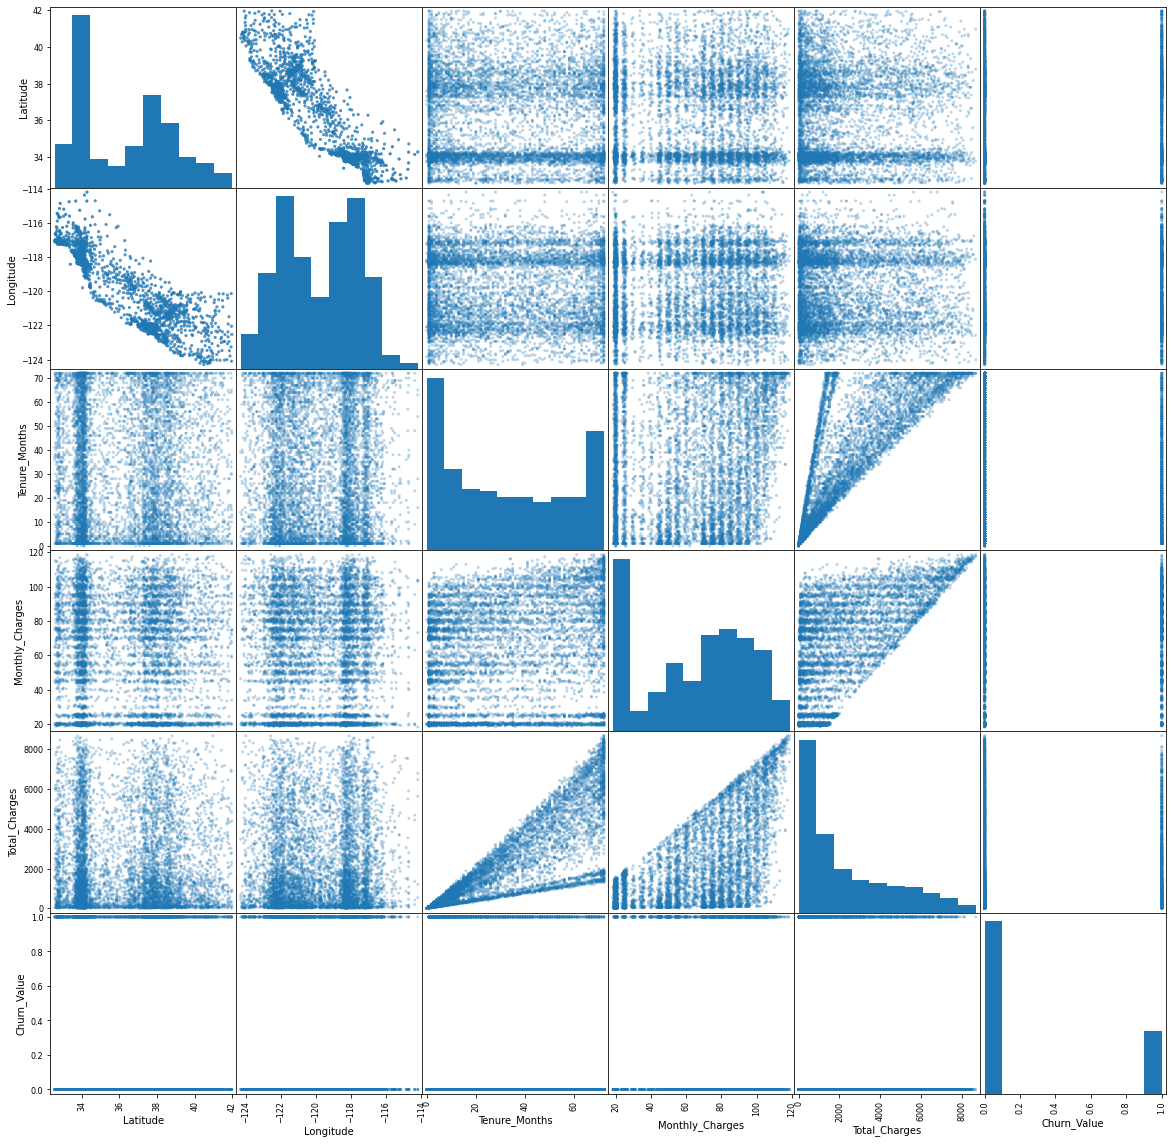

In [ ]:
pd.plotting.scatter_matrix(df, alpha=0.3, figsize=(20, 20))

In [ ]:
df.corr()

,Latitude,Longitude,Tenure_Months,Monthly_Charges,Total_Charges,Churn_Value
Latitude,1.000000,-0.876779,-0.001631,-0.019899,-0.009944,-0.003384
Longitude,-0.876779,1.000000,-0.001678,0.024098,0.008876,0.004594
Tenure_Months,-0.001631,-0.001678,1.000000,0.247900,0.826178,-0.352229
Monthly_Charges,-0.019899,0.024098,0.247900,1.000000,0.651174,0.193356
Total_Charges,-0.009944,0.008876,0.826178,0.651174,1.000000,-0.198324
Churn_Value,-0.003384,0.004594,-0.352229,0.193356,-0.198324,1.000000


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pylab
import math

In [ ]:
def normality(data):
    _, p = stats.shapiro(data)
    print(f'Normality test: {p}')
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    sns.kdeplot(data)
    plt.subplot(1,2,2)
    stats.probplot(data,plot=pylab)
    plt.show()

In [ ]:
def log_trasformation(x):
  return np.exp(x)
#df['Total_Charges'].apply(log_trasformation).hist()
list(sorted(set(df['Total_Charges'])))[-2]

8672.45

# Format Data 1: Split Data in Dependent and Independent Variables

In [ ]:
X = df.drop('Churn_Value', axis=1).copy()
y = df['Churn_Value'].copy()

# Format Data 2: One-Hot Encoding

In [ ]:
X.columns

Index(['City', 'Latitude', 'Longitude', 'Gender', 'Senior_Citizen', 'Partner',
       'Dependents', 'Tenure_Months', 'Phone_Service', 'Multiple_Lines',
       'Internet_Service', 'Online_Security', 'Online_Backup',
       'Device_Protection', 'Tech_Support', 'Streaming_TV', 'Streaming_Movies',
       'Contract', 'Paperless_Billing', 'Payment_Method', 'Monthly_Charges',
       'Total_Charges'],
      dtype='object')

In [ ]:
# XGBoost does not support categorical data, so we need to convert them in 
# numerical discrete values, ie one-hot encode them. 
X_encoded = pd.get_dummies(X, columns=['City', 
                                        'Gender', 
                                        'Senior_Citizen',
                                        'Partner', 
                                        'Dependents', 
                                        'Phone_Service',
                                        'Multiple_Lines', 
                                        'Internet_Service', 
                                        'Online_Security',
                                        'Online_Backup', 
                                        'Device_Protection', 
                                        'Tech_Support', 
                                        'Streaming_TV',
                                        'Streaming_Movies', 
                                        'Contract', 
                                        'Paperless_Billing', 
                                        'Payment_Method'])

# XGBoost Model 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, stratify=y, random_state=1)

In [ ]:
xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', 
                                   missing=None, 
                                   seed=1)
xgb_classifier.fit(X_train, 
                   y_train, 
                   early_stopping_rounds=10, 
                   eval_metric='aucpr', 
                   eval_set=[(X_test, y_test)], 
                   verbose=True)

[0]	validation_0-aucpr:0.57562
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.578622
[2]	validation_0-aucpr:0.584347
[3]	validation_0-aucpr:0.621109
[4]	validation_0-aucpr:0.620394
[5]	validation_0-aucpr:0.62845
[6]	validation_0-aucpr:0.62478
[7]	validation_0-aucpr:0.630216
[8]	validation_0-aucpr:0.643242
[9]	validation_0-aucpr:0.645068
[10]	validation_0-aucpr:0.647533
[11]	validation_0-aucpr:0.648869
[12]	validation_0-aucpr:0.652777
[13]	validation_0-aucpr:0.662993
[14]	validation_0-aucpr:0.664409
[15]	validation_0-aucpr:0.667318
[16]	validation_0-aucpr:0.667384
[17]	validation_0-aucpr:0.667954
[18]	validation_0-aucpr:0.668558
[19]	validation_0-aucpr:0.670423
[20]	validation_0-aucpr:0.670766
[21]	validation_0-aucpr:0.669025
[22]	validation_0-aucpr:0.672135
[23]	validation_0-aucpr:0.67502
[24]	validation_0-aucpr:0.675817
[25]	validation_0-aucpr:0.676842
[26]	validation_0-aucpr:0.677612
[27]	validation_0-aucpr:0.678472
[28]	validation_0-aucpr:

XGBClassifier(seed=1)

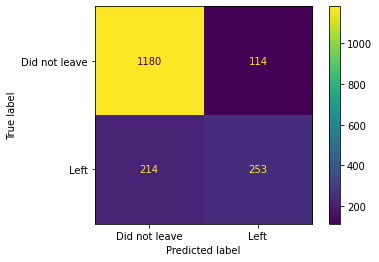

In [ ]:
ConfusionMatrixDisplay.from_estimator(xgb_classifier, X_test, y_test, display_labels=["Did not leave", "Left"])

[0.0078766  0.00690558 0.03614161 ... 0.         0.05263808 0.        ]


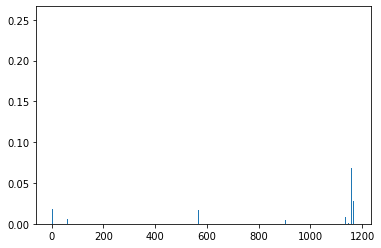

In [ ]:
print(xgb_classifier.feature_importances_)
# plot
plt.bar(range(len(xgb_classifier.feature_importances_)), xgb_classifier.feature_importances_)
plt.show()

In [ ]:
feats = list(zip(xgb_classifier.get_booster().feature_names, xgb_classifier.feature_importances_))
feats.sort(key=lambda x: x[1])
feats[-20:]

[('Senior_Citizen_No', 0.008018753),
 ('Phone_Service_No', 0.008455669),
 ('Partner_No', 0.011882285),
 ('Multiple_Lines_No', 0.012951109),
 ('Internet_Service_No', 0.015670542),
 ('Paperless_Billing_No', 0.01657352),
 ('City_Los_Angeles', 0.016619153),
 ('Total_Charges', 0.017524227),
 ('Monthly_Charges', 0.01768093),
 ('Contract_One year', 0.024659045),
 ('Streaming_Movies_Yes', 0.028168412),
 ('Online_Backup_No', 0.030150956),
 ('Tenure_Months', 0.036141608),
 ('Dependents_No', 0.0447488),
 ('Payment_Method_Electronic check', 0.052638076),
 ('Contract_Two year', 0.053960953),
 ('Tech_Support_No', 0.06867183),
 ('Online_Security_No', 0.08118019),
 ('Internet_Service_Fiber optic', 0.11888647),
 ('Contract_Month-to-month', 0.25371537)]

## XGBoost Hyperparameters Optimization

In [ ]:
imortant_feats=['Latitude',
 'Streaming_TV_No',
 'City_Los_Angeles',
 'Gender_Female',
 'City_Brawley',
 'City_Miramonte',
 'City_Santa_Barbara',
 'Gender_Male',
 'Senior_Citizen_No',
 'Phone_Service_Yes',
 'Paperless_Billing_No',
 'Partner_No',
 'Multiple_Lines_No',
 'City_Duarte',
 'Payment_Method_Bank transfer (automatic)',
 'Senior_Citizen_Yes',
 'Online_Backup_Yes',
 'Partner_Yes',
 'Multiple_Lines_Yes',
 'Monthly_Charges',
 'Streaming_TV_Yes',
 'Streaming_Movies_No',
 'Internet_Service_DSL',
 'Total_Charges',
 'Online_Backup_No',
 'Paperless_Billing_Yes',
 'Streaming_Movies_Yes',
 'Tenure_Months',
 'Internet_Service_No',
 'Tech_Support_No',
 'Dependents_No',
 'Payment_Method_Electronic check',
 'Dependents_Yes',
 'Device_Protection_No',
 'Internet_Service_Fiber optic',
 'Contract_One year',
 'Online_Security_No',
 'Contract_Month-to-month',
 'Contract_Two year']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded[imortant_feats], y, stratify=y, random_state=1)

In [ ]:
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [.1, .01, .05], 
    'gamme': [0, .25, 1], 
    'reg_lambda': [0, 1, 10], 
    'scale_pos_weight': [1, 3, 5]
}
optimal_params = GridSearchCV(
    estimator=xgb.XGBClassifier(objective='binary:logistic', 
                                subsample=0.9, 
                                colsample_bytree=0.5, 
                                seed=1), 
    param_grid=param_grid, 
    scoring='roc_auc', 
    verbose=0, 
    n_jobs=10, 
    cv=3
                              
)

In [ ]:
"""optimal_params.fit(X_train, 
                   y_train, 
                   early_stopping_rounds=10, 
                   eval_metric='auc', 
                   eval_set=[(X_test, y_test)], 
                   verbose=True)
optimal_params.best_params_"""

# Evaluation XGBoost Model

In [ ]:
xgb_classifier = xgb.XGBClassifier(objective='binary:logistic',
                                   gamma=.25, 
                                   learn_rate=.1, 
                                   max_depth=4, 
                                   reg_lambda=10, 
                                   scale_pos_weight=3, 
                                   subsample=.9,
                                   colsample_bytree=.5, 
                                   seed=1)
"""xgb_classifier = xgb.XGBClassifier(objective='binary:logistic',
                                   gamma=.0, 
                                   learn_rate=.05, 
                                   max_depth=4, 
                                   reg_lambda=1, 
                                   scale_pos_weight=3, 
                                   subsample=.9,
                                   colsample_bytree=.5, 
                                   seed=1)"""
xgb_classifier.fit(X_train, 
                   y_train, 
                   early_stopping_rounds=10, 
                   eval_metric='aucpr', 
                   eval_set=[(X_test, y_test)], 
                   verbose=True)

[0]	validation_0-aucpr:0.53968
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.577968
[2]	validation_0-aucpr:0.624353
[3]	validation_0-aucpr:0.635188
[4]	validation_0-aucpr:0.633721
[5]	validation_0-aucpr:0.63383
[6]	validation_0-aucpr:0.634856
[7]	validation_0-aucpr:0.635847
[8]	validation_0-aucpr:0.654474
[9]	validation_0-aucpr:0.671043
[10]	validation_0-aucpr:0.668196
[11]	validation_0-aucpr:0.670443
[12]	validation_0-aucpr:0.670452
[13]	validation_0-aucpr:0.675115
[14]	validation_0-aucpr:0.675117
[15]	validation_0-aucpr:0.677635
[16]	validation_0-aucpr:0.676232
[17]	validation_0-aucpr:0.678557
[18]	validation_0-aucpr:0.680677
[19]	validation_0-aucpr:0.682561
[20]	validation_0-aucpr:0.68464
[21]	validation_0-aucpr:0.6855
[22]	validation_0-aucpr:0.684191
[23]	validation_0-aucpr:0.685473
[24]	validation_0-aucpr:0.689096
[25]	validation_0-aucpr:0.690288
[26]	validation_0-aucpr:0.690695
[27]	validation_0-aucpr:0.692552
[28]	validation_0-aucpr:0

XGBClassifier(colsample_bytree=0.5, gamma=0.25, learn_rate=0.1, max_depth=4,
              reg_lambda=10, scale_pos_weight=3, seed=1, subsample=0.9)

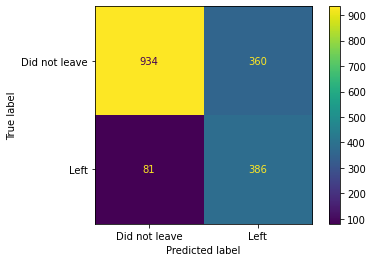

In [ ]:
ConfusionMatrixDisplay.from_estimator(xgb_classifier, X_test, y_test, display_labels=["Did not leave", "Left"])

[0.00713658 0.00434285 0.00639937 0.00420146 0.         0.
 0.00509212 0.00770649 0.00621825 0.00540964 0.01041936 0.01159962
 0.00734881 0.00946841 0.00436234 0.0054898  0.00790723 0.00998944
 0.00774264 0.01071937 0.01840063 0.0092889  0.01647132 0.01354287
 0.01681729 0.0067687  0.01086238 0.01788626 0.01516278 0.01824231
 0.03585559 0.03187184 0.03999092 0.00570111 0.05408614 0.01335723
 0.05892007 0.33426097 0.15095894]


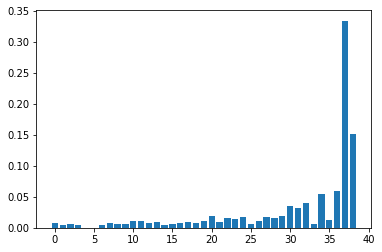

In [ ]:
print(xgb_classifier.feature_importances_)
# plot
plt.bar(range(len(xgb_classifier.feature_importances_)), xgb_classifier.feature_importances_)
plt.show()

In [ ]:
feats = list(zip(xgb_classifier.get_booster().feature_names, xgb_classifier.feature_importances_))
feats.sort(key=lambda x: x[1])
feats[-20:]

[('Partner_Yes', 0.0099894395),
 ('Paperless_Billing_No', 0.010419362),
 ('Monthly_Charges', 0.010719371),
 ('Streaming_Movies_Yes', 0.01086238),
 ('Partner_No', 0.011599623),
 ('Contract_One year', 0.013357228),
 ('Total_Charges', 0.013542873),
 ('Internet_Service_No', 0.015162785),
 ('Internet_Service_DSL', 0.016471323),
 ('Online_Backup_No', 0.01681729),
 ('Tenure_Months', 0.017886264),
 ('Tech_Support_No', 0.018242313),
 ('Streaming_TV_Yes', 0.018400626),
 ('Payment_Method_Electronic check', 0.031871837),
 ('Dependents_No', 0.03585559),
 ('Dependents_Yes', 0.039990924),
 ('Internet_Service_Fiber optic', 0.05408614),
 ('Online_Security_No', 0.058920067),
 ('Contract_Two year', 0.15095894),
 ('Contract_Month-to-month', 0.33426097)]

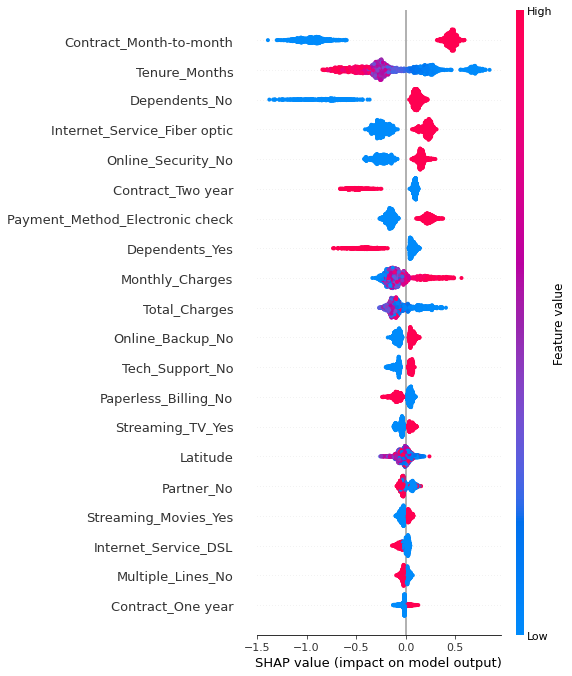

In [ ]:
sv = shap.TreeExplainer(xgb_classifier).shap_values(X_test)
shap.summary_plot(sv, X_test)

# Costumer Segmentation

# Standardize Variables

In [ ]:
col_names = ['Latitude', 'Longitude', 'Tenure_Months', 'Monthly_Charges', 'Total_Charges']
features = df[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
scaled_features = pd.DataFrame(features, columns = col_names)
scaled_features.head()

,Latitude,Longitude,Tenure_Months,Monthly_Charges,Total_Charges
0,-0.944111,0.707268,-1.236724,-0.362660,-0.958066
1,-0.905362,0.691215,-1.236724,0.197365,-0.938874
2,-0.909951,0.697457,-0.992402,1.159546,-0.643789
3,-0.904204,0.687374,-0.177995,1.330711,0.338085
4,-0.913530,0.710276,0.677133,1.294151,1.216150


## One-Hot Encoding

In [ ]:
cols=['City', 'Gender', 'Senior_Citizen', 'Partner', 'Dependents','Phone_Service',
       'Multiple_Lines', 'Internet_Service', 'Online_Security',
       'Online_Backup', 'Device_Protection', 'Tech_Support', 'Streaming_TV',
       'Streaming_Movies', 'Contract', 'Paperless_Billing', 'Payment_Method',] 

newdf = pd.get_dummies(df, columns=cols)
col_names = ['Latitude', 'Longitude', 'Tenure_Months', 'Monthly_Charges', 'Total_Charges']
newdf = newdf.drop(['Latitude', 'Longitude', 'Tenure_Months', 'Monthly_Charges', 'Total_Charges'],axis=1)
newdf = scaled_features.join(newdf)

newdf.head()



,Latitude,Longitude,Tenure_Months,Monthly_Charges,Total_Charges,Churn_Value,cluster,City_Acampo,City_Acton,City_Adelanto,...,Streaming_Movies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,Paperless_Billing_No,Paperless_Billing_Yes,Payment_Method_Bank transfer (automatic),Payment_Method_Credit card (automatic),Payment_Method_Electronic check,Payment_Method_Mailed check
0,-0.944111,0.707268,-1.236724,-0.362660,-0.958066,1,1,0,0,0,...,0,1,0,0,0,1,0,0,0,1
1,-0.905362,0.691215,-1.236724,0.197365,-0.938874,1,1,0,0,0,...,0,1,0,0,0,1,0,0,1,0
2,-0.909951,0.697457,-0.992402,1.159546,-0.643789,1,1,0,0,0,...,1,1,0,0,0,1,0,0,1,0
3,-0.904204,0.687374,-0.177995,1.330711,0.338085,1,2,0,0,0,...,1,1,0,0,0,1,0,0,1,0
4,-0.913530,0.710276,0.677133,1.294151,1.216150,1,0,0,0,0,...,1,1,0,0,0,1,1,0,0,0


## Building the K-**Means** model

Text(0, 0.5, 'Inertia')

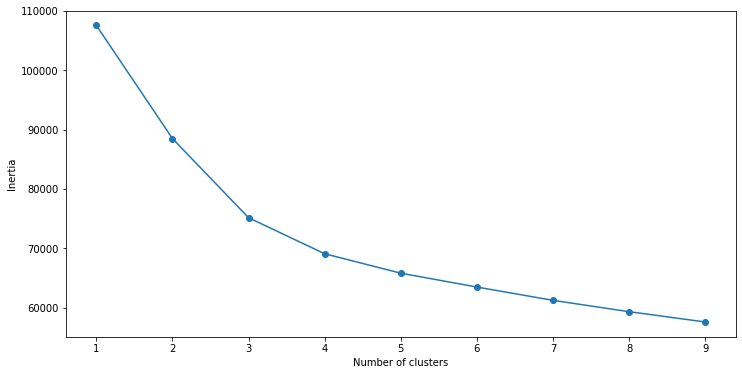

In [ ]:
SSE = []

for cluster in range(1,10):
    kmeans = KMeans(n_clusters = cluster, init='k-means++')
    kmeans.fit(newdf)
    SSE.append(kmeans.inertia_)

# converting the results into a dataframe and plotting them

frame = pd.DataFrame({'Cluster':range(1,10), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

# Silhouette coefficient


In [ ]:
# First, build a model with 4 clusters

kmeans = KMeans(n_clusters = 4, init='k-means++')
kmeans.fit(newdf)

# Now, print the silhouette score of this model

print(silhouette_score(newdf, kmeans.labels_, metric='euclidean'))

0.1730954321285865


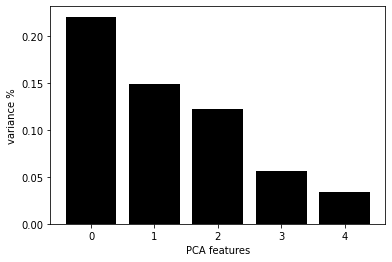

In [ ]:
pca = PCA(n_components=5)
principalComponents = pca.fit_transform(newdf)

features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

PCA_components = pd.DataFrame(principalComponents)

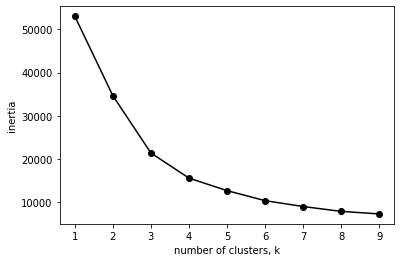

In [ ]:
ks = range(1, 10)
inertias = []

for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(PCA_components.iloc[:,:3])
    inertias.append(model.inertia_)

plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [ ]:
model = KMeans(n_clusters=4)
model.fit(PCA_components.iloc[:,:3])

# silhouette score
print(silhouette_score(PCA_components.iloc[:,:3], model.labels_, metric='euclidean')) 

0.41391919609953975


In [ ]:
# map back clusters to dataframe

pred = model.predict(PCA_components.iloc[:,:3])
frame = pd.DataFrame(df)
frame['cluster'] = pred
frame.head()

,City,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,Multiple_Lines,...,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Value,cluster
0,Los_Angeles,33.964131,-118.272783,Male,No,No,No,2,Yes,No,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,0
1,Los_Angeles,34.059281,-118.307420,Female,No,No,Yes,2,Yes,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,0
2,Los_Angeles,34.048013,-118.293953,Female,No,No,Yes,8,Yes,Yes,...,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.50,1,0
3,Los_Angeles,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,Yes,...,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1,0
4,Los_Angeles,34.039224,-118.266293,Male,No,No,Yes,49,Yes,Yes,...,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.30,1,1


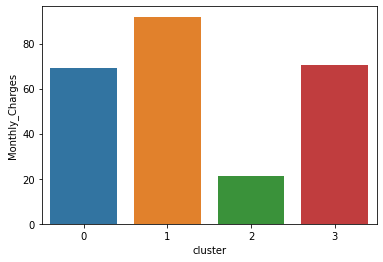

In [ ]:
avg_df = frame.groupby(['cluster'], as_index=False).mean()
sns.barplot(x='cluster',y='Monthly_Charges',data=avg_df)

In [ ]:
pd.DataFrame(df.groupby(['cluster','Churn_Value'])['Churn_Value'].count())

Churn_Value
cluster Churn_Value             
0       0                   1135
        1                    778
1       0                   1553
        1                    216
2       0                   1414
        1                    113
3       0                   1072
        1                    762